        Aerosol- und Nanotechnologie II | Friederike Baumgart | Matr.-Nr. 4343944 | Abgabe: 01.05.22

# Aufgabe 2

Ziel der vorangegangenen Aufgabe war die Bestimmung von Partikelverteilungen in einem kontinuierlichen Rührkesselreaktor im stationären Zustand. In dieser Aufgabe soll zusätzlich die zeitliche Abhängigkeit berücksichtigt werden.
Eine Massenbilanz für diesen Fall lässt sich wie folgt aufstellen:

$$
\frac{\partial n(v_\mathrm{p}, t)}{\partial t} = -B \Delta n + Q n_0(v_\mathrm{p, min}) - Q n(v_\mathrm{p}, t)
\label{eq:Bilanz}\tag{1}
$$

Mit der Definition

$$
\frac{\partial n(v_\mathrm{p}, t)}{\partial t} = \frac{n(t) - n(t-1)}{\Delta t}
\label{eq:dndt}\tag{2}
$$

lässt sich Gleichung [1](#mjx-eqn-eq:Bilanz)  zu

$$
n(t) = \frac{n(t-1) + Q n_0(v_\mathrm{min}) \Delta t - B \Delta n_\mathrm{formed}}{1 + Q \Delta t}
\label{eq:n}\tag{3}
$$

umstellen, wobei $\Delta n_\mathrm{formed} = \Delta n \cdot \Delta t$.

Wie in Aufgabe 1 werden zunächst mögliche Partikelgrößen festgelegt und in einen Vektor $vp$ geschrieben. Zusätzlich zu definieren sind die Zeit sowie die Zeitschritte der Integration. Des Weiteren werden Volumenstrom, Reaktorvolumen und Startwerte festgelegt.

In [2]:
import numpy as np
from matplotlib import pyplot as plt


dp_min = 0.5e-9                          # in m
dp_max = 1000e-9                         # in m
vp_min = np.pi/6 * (dp_min)**3           # in m^3
vp_max = np.pi/6 * (dp_max)**3           # in m^3
vp_num = int(np.log(vp_max / vp_min) // np.log(2) + 2)
vp = np.zeros((vp_num))
for i in range(vp_num): 
    vp[i] = vp_min * 2**i 
    
n = np.zeros((vp_num))
t_total = 50e-0                          # in s
nt = 10000                               # Iterationsschritte
dt = t_total / nt                        # in s, Zeit zwischen Iterationsschritten

n_0 = np.zeros((vp_num))
start_bin = 1                 
n_0[start_bin] = 1e17      # in #/m^3
n = n_0.copy()                 

Q = 0.5                    # in m^3/s, Volumenstrom
B = 1                      # in m^3, Reaktorvolumen
N_0 = 1e17                 # in #/m^3

n_zeit = np.zeros((nt))    # Vektor mit einer Stelle für jeden Iterationsschritt

Die Koagulation zwischen zwei Partikeln $i$ und $j$ mit dem Koagulationskoeffizienten $\beta$ wird durch die Smoluchowski-Gleichung

$$
\frac{\partial n_\mathrm{formed}(v_\mathrm{p},t)}{\partial t} =
\frac{1}{2}\int_0^{v_\mathrm{p}} \beta(\tilde{v_\mathrm{p}},v_\mathrm{p}-\tilde{v_\mathrm{p}}) \, n(\tilde{v_\mathrm{p}},t) \, n(v_\mathrm{p}-\tilde{v_\mathrm{p}},t) \, d\tilde{v_\mathrm{p}} 
- \int_0^{\infty} \beta(v_\mathrm{p},\tilde{v_\mathrm{p}}) \, n(v_\mathrm{p},t) \, n(\tilde{v_\mathrm{p}},t) \, d\tilde{v_\mathrm{p}}
\label{eq:Smoluchowski}\tag{4}
$$

beschrieben. Hounslow et al. (1988) diskretisierten diese Gleichung wie folgt:

$$
\dfrac{\mathrm{d} N_i}{\mathrm{d} t} = \,  N_{i-1} \sum_{j=1}^{i-2} 2^{j-i+1} \, \beta_{i-1,j} \, N_j
+ \frac{1}{2} \, \beta_{i-1,i-1} \, N_{i-1}^2 \\
 - N_{i} \sum_{j=1}^{i-1} 2^{j-i} \, \beta_{i,j} \, N_j
- N_{i} \sum_{j=i}^{\infty} \beta_{i,j} \, N_j
\label{eq:dndt}\tag{5}
$$

Im Kontinuum ergibt sich $\beta$ durch

$$
\beta (v_i, v_j) = \frac{2 k_B T}{3 \mu} \left( \frac{1}{v_i^\frac{1}{3}} + \frac{1}{v_j^\frac{1}{3}} \right) \left( v_i^\frac{1}{3} + v_j^\frac{1}{3} \right).
\label{eq:beta}\tag{6}
$$

Um Gleichung [3](#mjx-eqn-eq:n) zu lösen, wird zunächst $\beta$ mit Gleichung [6](#mjx-eqn-eq:beta) für alle möglichen Partikelkombinationen berechnet.

In [3]:
T = 293                                  # in K
rho_p = 1.0e3                            # in kg / m^3
k_B = 1.380649e-23                       # in kg m^2 /( s^2 K), Boltzmann-Konstante
mu = 17.2e-6                             # in Pa*s, dynamische Viskosität Luft 

beta_pre = (2*k_B*T)/(3*mu)  
beta_n = np.zeros((vp_num, vp_num))
for i in range(vp_num): 
    for j in range(vp_num): 
        beta_n[i,j] = beta_pre * (1/vp[i]**(1/3) + 1/vp[j]**(1/3)) *(vp[i]**(1/3) + vp[j]**(1/3))

Um Gleichung [5](#mjx-eqn-eq:dndt) zu lösen, werden für bessere Übersichtlichkeit zunächst die drei Summenelemente berechnet. Anschließend werden diese in die Gleichung eingesetzt. Durch Multiplikation mit $\Delta t$ ergibt sich $\Delta n_\mathrm{formed}$, was in Gleichung [3](#mjx-eqn-eq:n) eingesetzt wird.

In [4]:
n_formed = np.zeros((vp_num))
nn = np.empty_like(n)

for t in range(nt - 1):
    nn = n.copy()
    for i in range(1, vp_num, 1):
        
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        
        if i == 1:
            for j in range(0, i - 0, 1):    
                sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
            for j in range(i, vp_num - 1, 1): 
                sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
                
            n_formed[i] = dt *(- nn[i] * sum2[i] - nn[i] * sum3[i])  
            n[i] = (nn[i] + Q*N_0*dt + B*n_formed[i]) /(1+Q*dt)

        else:
            for j in range(0, i - 1, 1):
                sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
            for j in range(0, i - 0, 1):    
                sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
            for j in range(i, vp_num - 1, 1): 
                sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
                
            n_formed[i] = dt *(nn[i-1] * sum1[i] + 1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - nn[i] * sum2[i] - nn[i] * sum3[i])  
            n[i] = (nn[i] + B*n_formed[i]) /(1+Q*dt)


Zum Vergleich wird, wie in Aufgabe 1, die analytische Lösung berechnet.

In [5]:
def an_n(v): # analytic solution
    return (1/(A * v**(1/3.0))) * np.exp((3/2.0) * (vp_min**(2/3.0) - v**(2/3.0))/(A * tau)) * (N_0 / tau)

tau = B/Q  # Verweilzeit
A = 1e-1
n_an = np.zeros(vp_num)
for j in range(1, vp_num, 1):
    n_an[j] = an_n(vp[j])


In [7]:
n

array([0.00000000e+00, 6.16504301e+15, 1.98789755e+15, 1.18878061e+15,
       7.75476245e+14, 5.16356645e+14, 3.38622503e+14, 2.10766764e+14,
       1.18224921e+14, 5.54817067e+13, 1.98001539e+13, 4.85650823e+12,
       7.53646836e+11, 7.05322743e+10, 3.91888965e+09, 1.29499507e+08,
       2.56376203e+06, 3.06515843e+04, 2.22932427e+02, 9.92657236e-01,
       2.72050901e-03, 4.60911050e-06, 4.84377536e-09, 3.16548659e-12,
       1.28850936e-15, 3.26921398e-19, 5.16965349e-23, 5.09064328e-27,
       3.11710885e-31, 1.18468649e-35, 2.78901086e-40, 4.05896515e-45,
       3.64488792e-50, 2.01625280e-55])

In [8]:
n2 = np.array([0.00000000e+00, 6.88029390e+16, 5.07024012e+16, 4.04306052e+16,
 3.59583613e+16, 3.17324608e+16, 2.74927209e+16, 2.45454302e+16,
 2.43469353e+16, 2.32054670e+16, 1.59017249e+16, 6.24750307e+15,
 1.20537641e+15, 1.04750930e+14, 4.06366413e+12, 7.35281631e+10,
 6.54011055e+08, 2.98429618e+06, 7.22036633e+03, 9.50595907e+00,
 6.95211872e-03, 2.87162152e-06, 6.78976666e-10, 9.29060734e-14,
 7.42298027e-18, 3.48863463e-22, 9.70345515e-27, 1.60547501e-31,
 1.58689227e-36, 9.40448348e-42, 3.35207313e-47, 7.20516725e-53,
 9.36128634e-59, 7.36668009e-65])

In [9]:
n - n2

array([ 0.00000000e+00, -6.26378960e+16, -4.87145036e+16, -3.92418246e+16,
       -3.51828851e+16, -3.12161042e+16, -2.71540984e+16, -2.43346634e+16,
       -2.42287104e+16, -2.31499853e+16, -1.58819247e+16, -6.24264656e+15,
       -1.20462276e+15, -1.04680398e+14, -4.05974524e+12, -7.33986636e+10,
       -6.51447293e+08, -2.95364460e+06, -6.99743390e+03, -8.51330183e+00,
       -4.23160971e-03,  1.73748898e-06,  4.16479869e-09,  3.07258052e-12,
        1.28108638e-15,  3.26572535e-19,  5.16868315e-23,  5.09048274e-27,
        3.11709298e-31,  1.18468555e-35,  2.78901052e-40,  4.05896508e-45,
        3.64488791e-50,  2.01625280e-55])

Abschließend werden die Ergebnisse graphisch dargestellt.

<IPython.core.display.Javascript object>


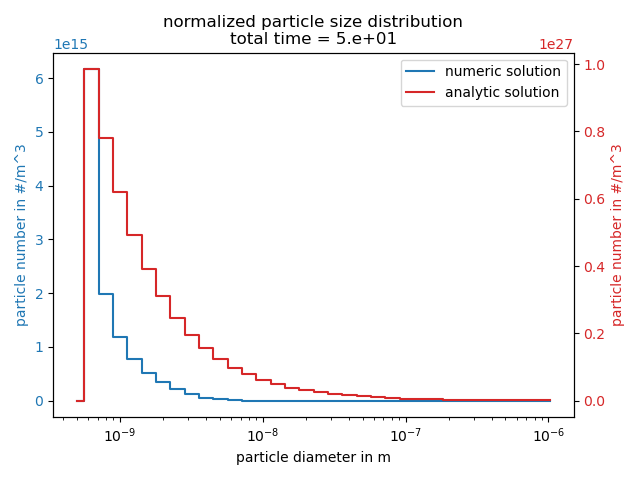

In [6]:
%matplotlib notebook
dp_start = np.zeros((vp_num))
dp_end = np.zeros((vp_num))
dp_start = (6/np.pi * vp[start_bin])**(1/3)
dp_end = (6/np.pi * vp)**(1/3)

fig, ax1 = plt.subplots()
color1 = "tab:blue"
ax1.semilogx(dp_end, n, drawstyle="steps-mid", \
             label="numeric solution", color = color1) 
ax1.set_ylabel("particle number in #/m^3", color = color1)
ax1.tick_params(axis="y", labelcolor = color1)
title_string = "normalized particle size distribution" + "\n" + \
    "total time = " + \
    str(np.format_float_scientific(t_total, precision=0))
ax1.set_title(title_string)
ax1.set_xlabel("particle diameter in m")

color2 = "tab:red"
ax2 = ax1.twinx() 
ax2.semilogx(dp_end, n_an, drawstyle="steps-mid", \
             label="analytic solution", color = color2) 
ax2.set_ylabel("particle number in #/m^3", color = color2)
ax2.tick_params(axis="y", labelcolor = color2)
#ax2.set_ylim(1.2e24,1.22e24)


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

plt.tight_layout()
plt.show()

## Literatur

Hounslow, M., Ryall, R., Marshall, V. "A discretized population balance for nucleation, growth, and aggregation", AIChE journal, 34 (11) 1821-1832 (1988).